In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

In [ ]:
# Update the file paths to dataset location
csv_file_names = ['/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
                  '/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
                  '/content/Friday-WorkingHours-Morning.pcap_ISCX.csv',
                  '/content/Monday-WorkingHours.pcap_ISCX.csv',
                  '/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
                  '/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
                  '/content/Tuesday-WorkingHours.pcap_ISCX.csv',
                  '/content/Wednesday-workingHours.pcap_ISCX.csv']
full_path = [f'/path_to_your_data/{name}' for name in csv_file_names]
df = pd.concat(map(pd.read_csv, csv_file_names), ignore_index=True)


In [ ]:
print(df.head())
print(df.info())

In [ ]:
# Rename the column to remove the leading space
df.rename(columns={' Label': 'Label'}, inplace=True)

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define numeric and categorical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Remove the target column 'Label' from categorical features if it's there
categorical_features = categorical_features.drop('Label') if 'Label' in categorical_features else categorical_features

# Transformation pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformations into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Separate features and target variable
X = df.drop('Label', axis=1)
y = df['Label']

# Apply transformations
X_preprocessed = preprocessor.fit_transform(X)

# Encode the target variable for multi-class classification
label_encoder = LabelEncoder()
y_integer_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_integer_encoded)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_categorical, test_size=0.2, random_state=42)


In [ ]:
num_classes = y_categorical.shape[1]
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # One neuron per class
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
56615/56615 [==============================] - 184s 3ms/step - loss: 0.0645 - accuracy: 0.9744 - val_loss: 0.0515 - val_accuracy: 0.9796
Epoch 2/10
56615/56615 [==============================] - 183s 3ms/step - loss: 0.0445 - accuracy: 0.9824 - val_loss: 0.0366 - val_accuracy: 0.9831
Epoch 3/10
56615/56615 [==============================] - 182s 3ms/step - loss: 0.0351 - accuracy: 0.9880 - val_loss: 0.0302 - val_accuracy: 0.9886
Epoch 4/10
56615/56615 [==============================] - 183s 3ms/step - loss: 0.0328 - accuracy: 0.9894 - val_loss: 0.0295 - val_accuracy: 0.9926
Epoch 5/10
56615/56615 [==============================] - 182s 3ms/step - loss: 0.0325 - accuracy: 0.9900 - val_loss: 0.0251 - val_accuracy: 0.9918
Epoch 6/10
56615/56615 [==============================] - 183s 3ms/step - loss: 0.0316 - accuracy: 0.9906 - val_loss: 0.0254 - val_accuracy: 0.9915
Epoch 7/10
56615/56615 [==============================] - 181s 3ms/step - loss: 0.0292 - accuracy: 0.9913 - val_

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


17693/17693 [==============================] - 38s 2ms/step - loss: 0.0231 - accuracy: 0.9919
Test Loss: 0.023090090602636337, Test Accuracy: 0.9918643236160278


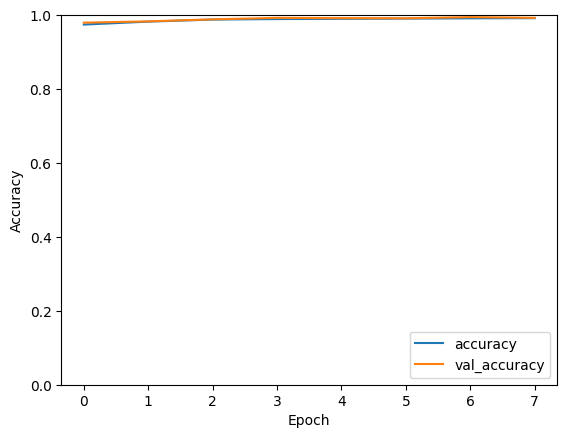

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


In [ ]:
model.save('model.h5')
joblib.dump(preprocessor, 'my_preprocessor.pkl')
preprocessor = joblib.load('my_preprocessor.pkl')


In [ ]:
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

# Load trained model
model = tf.keras.models.load_model('model.h5')

# Load preprocessor
import joblib
preprocessor = joblib.load('my_preprocessor.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        json_ = request.json
        query_df = pd.DataFrame(json_)
        query = preprocessor.transform(query_df)
        prediction = model.predict(query)

        return jsonify({'prediction': prediction.tolist()})
    except Exception as e:
        return jsonify({'error': str(e), 'trace': traceback.format_exc()})

if __name__ == "__main__":
    app.run()

In [ ]:
python app.py

In [ ]:
curl -X POST -H "Content-Type: application/json" -d @data.json http://127.0.0.1:5000/predict